# Introduction

This notebook contains the data analysis of pre- and post survey results relating to phase I of the iAdapt project. The latest version is always available [here, on Github](https://github.com/urschrei/iadapt_analysis) and as a [deposit on Zenodo](https://doi.org/10.5281/zenodo.8114518).

In step 1, Likert data from the results are first converted to ordinal values, then analysed using the Mann-Whitney U test and the t test. Statistically significant question results have a Cohen's d and Hedge's G effect assigned.

In step 2, pre- and post question data are graphed in small multiples according to their capability grouping, for further discussion.

**Note:** `Start time` and `ID` are not used in this analysis but are retained for data quality and assurance reasons, allowing them to be matched with the retained read-only survey response data if necessary.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

from statsmodels.stats.nonparametric import rank_compare_2indep
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import TTestIndPower

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# skip if you dont' use Latex
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

In [5]:
ecc = '#000000'
ecw = 0.25
histcolors = ["#008080", "#980043"]

# Step 1: convert Likert data to ordinal values

In [6]:
qs = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8", "Q9", "Q10", "Q11", "Q12"]

# rename questions for ease of handling
questions_sub = {
    "I think about climate change": "Q1",
    "I think the world's climate is changing": "Q2",
    "I'm worried about the effects of climate change on my community": "Q3",
    "I think it's too late to do anything about climate change": "Q4",
    "I know about the history of flooding in my community": "Q5",
    "I know what the government and local authority are doing to help my community to cope with climate change": "Q6",
    "I understand the difference between climate change mitigation and climate change adaptation": "Q7",
    "I think technology is the most important tool we have to help us to adapt to climate change": "Q8",
    "I think interactive maps are a useful tool for talking about and demonstrating the effects of climate change": "Q9",
    "Games are a good way to help us to imagine the effects of climate change": "Q10",
    "Imagining what our lives will be like in the future is a good way to discuss adaptation to climate change": "Q11",
    "I think that changing my own behaviour can help to limit the effects of climate change": "Q12"
}

# allow original question text to be looked up using Q[n]
flipped = dict((v, k) for k, v in questions_sub.items())

# Assign ordinal values to Likert questions
values_sub = {
    "Never": 1,
    "Rarely": 2,
    "Sometimes": 3,
    "Often": 4,
    "Very often": 5,
    "All the time": 6,
    "Definitely not changing": 1,
    "Probably not changing": 2,
    "Maybe changing": 3,
    "Probably changing": 4,
    "Definitely changing": 5,
    "Climate change isn't happening": 1,
    "Not worried at all": 2,
    "Neutral": 3,
    "A little worried": 4,
    "Very worried": 5,
    "Extremely worried": 6,
    "Strongly disagree": 1,
    "Disagree": 2,
    "Neutral": 3,
    "Agree": 4,
    "Strongly agree": 5,
}

In [7]:
df = pd.read_csv("survey_results.csv")
df.rename(columns=questions_sub, inplace=True)
df.replace(values_sub, inplace=True)
df.drop(columns=df.columns[0], axis=1, inplace=True)
df.head()

,ID,prepost,Start time,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,deis
0,132,pre,2022-09-13 13:59:10,2,4,2,3,2,1,1,4,3,4,4,3,True
1,127,pre,2022-09-13 13:59:26,1,2,1,3,1,1,1,3,3,4,3,1,True
2,128,pre,2022-09-13 13:59:26,2,5,4,2,4,1,3,5,3,4,4,5,True
3,131,pre,2022-09-13 13:59:26,2,5,4,2,3,3,4,4,4,4,4,4,True
4,129,pre,2022-09-13 13:59:27,3,5,3,3,1,2,2,3,3,4,4,3,True


In [8]:
len(df.query("prepost == 'pre'")), len(df.query("prepost == 'post'"))

(374, 239)

# Helper Functions
## Used for interpreting the Mann-Whitney U test results

In [9]:
def significant(pvalue):
    """
    Indicate significance at p < 0.05
    """
    if pvalue < 0.05:
        return f"{pvalue} *"
    else:
        return f"{pvalue}"


def size_cat(stat, q, effect):
    """
    Return Cohen's d / Hedge's g effect size category
    Size refers to standard deviations (the z statistic)
    """
    # sign isn't important when determining these since it depends on input order
    # (of MWU stat in this case)    
    if effect < 0:
        mean = "(Decreased Mean)"
    else:
        mean = ""
    effect = abs(effect)
    common = f"{stat} {q}: {effect}"
    if 0 <= effect < 0.18:
        s = common
    if 0.18 <= effect < 0.20:
        s = f"{common} <== Marginal Effect {mean}"
    elif 0.20 <= effect < 0.50:
        s = f"{common} <== Small Effect {mean}"
    elif 0.50 <= effect < 0.80:
        s = f"{common} <== Medium Effect {mean}"
    elif effect >= 0.80:
        s = f"{common} <== Large Effect {mean}"
    else:
        s = common
        # raise Exception("Effect less than 0!")
    return s

q_post = "prepost == 'post'"
q_pre = "prepost == 'pre'"


mwu_res = {q: rank_compare_2indep(
            df.query(q_post)[q],
            df.query(q_pre)[q],
            use_t=True) for q in qs
          }

# not currently used in analysis, but useful nevertheless
ttest_res = {q: ttest_ind(
            df.query(q_post)[q],
            df.query(q_pre)[q],
            ) for q in qs
          }

# Mann-Whitney U-Test Results, using `statsmodels`
## Statistically significant `p` values are indicated with a `*`
### Note: the `p` value assumes a `t` distribution

In [23]:
print("Significance of M-W U test stat\n")
for k, v in mwu_res.items():
    effectsize = round(mwu_res[k].effectsize_normal(), 2)
    # print(f"{k} ({v.statistic}): {significant(v.pvalue)}")
    print(size_cat(f"{k}: Cohen's d", f"(p: {significant(round(v.pvalue, 2))})", effectsize))

Significance of M-W U test stat

Q1: Cohen's d (p: 0.25): 0.09
Q2: Cohen's d (p: 0.39): 0.06
Q3: Cohen's d (p: 0.98): 0.0
Q4: Cohen's d (p: 0.02 *): 0.19 <== Marginal Effect (Decreased Mean)
Q5: Cohen's d (p: 0.81): 0.02
Q6: Cohen's d (p: 0.09): 0.14
Q7: Cohen's d (p: 0.0 *): 0.5 <== Medium Effect 
Q8: Cohen's d (p: 0.13): 0.12
Q9: Cohen's d (p: 0.15): 0.12
Q10: Cohen's d (p: 0.0 *): 0.25 <== Small Effect 
Q11: Cohen's d (p: 0.58): 0.04
Q12: Cohen's d (p: 0.68): 0.03


# `t` Test, using `statsmodels`

Whether it is appropriate to use the `t` test for non-normal data has been the subject of much debate. However, quoting from the [Minitab blog](https://blog.minitab.com/en/adventures-in-statistics-2/best-way-to-analyze-likert-item-data-two-sample-t-test-versus-mann-whitney):

> a simulation study conducted by de Winter and Dodou* that compares the capabilities of the two sample t-test and the Mann-Whitney test to analyze five-point Likert items for two groups. Is it better to use one analysis or the other?

> The researchers identified a diverse set of 14 distributions that are representative of actual Likert data. The computer program drew independent pairs of samples to test all possible combinations of the 14 distributions. All in all, 10,000 random samples were generated for each of the 98 distribution combinations! The pairs of samples are analyzed using both the two sample t-test and the Mann-Whitney test to compare how well each test performs. The study also assessed different sample sizes.

> The results show that for all pairs of distributions the Type I (false positive) error rates are very close to the target amounts. In other words, if you use either analysis and your results are statistically significant, you don’t need to be overly concerned about a false positive.


*See: de Winter, J. F. C., & Dodou, D. (2010). _Five-Point Likert Items: t test versus Mann-Whitney-Wilcoxon_. https://doi.org/10.7275/BJ1P-TS64


In [24]:
# bracketed value is the t statistic
for k, v in ttest_res.items():
    print(f"{k} ({v[0]}): {significant(v[1])}")

Q1 (0.9586342827825152): 0.33812218701840535
Q2 (0.9086939734837469): 0.3638699658905563
Q3 (-0.15698017864924627): 0.8753123274033848
Q4 (-2.5159789299901245): 0.012125424850854516 *
Q5 (0.11458525360934942): 0.9088115122793262
Q6 (1.5898209930935379): 0.11239242313255911
Q7 (6.034384414881475): 2.7671642067210632e-09 *
Q8 (1.4938597671113454): 0.1357284965513489
Q9 (1.264715435189148): 0.2064555298312976
Q10 (3.2067764173756315): 0.0014124212129911174 *
Q11 (-0.5751545762713809): 0.5653984918699984
Q12 (-0.019022932033505): 0.9848290218043585


# Hedge's g

> The Hedge's `g` statistic is **generally preferred** to Cohen's d statistic. It has better small sample properties and has better properties when the sample sizes are significantly different. For large samples where n1 and n2 are similar, the two statistics should be almost the same. The Glass `g` statistic may be preferred when the standard deviations are quite different.

In [26]:
def hedges(df, category_col, cat_a, cat_b, val_col):
    """
    Calculate Hedge's g effect size. Adapted from
    https://www.socscistatistics.com/effectsize/default3.aspx
    
    Hedge's g should be used when group standard deviation is similar
    but sample sizes are different (meaning Cohen's d can't be used)
    
    df: dataframe
    category_col: column containing categories used to group the samples
    cat_a: category identifying group a
    cat_b: category identifying group b
    val_col: column containing all values
    """
    # Sample sizes
    n = df.groupby(category_col).count()
    n1 = n[q][cat_a]
    n2 = n[q][cat_b]
    # Degrees of freedom
    dof = n.sum()[val_col] - 2
    # Variances
    variances = df.groupby(category_col).var(ddof=1, numeric_only=True)
    var1 = variances[val_col][cat_a]
    var2 = variances[val_col][cat_b]
    # Difference of the means
    diff_mean = abs(df.groupby(category_col).mean(numeric_only=True).diff()[val_col][-1])
    # Pooled standard deviation
    s_pooled_star = np.sqrt((((n1 - 1) * var1) + ((n2 - 1) * var2)) / dof)
    # Hedge's g
    return round(diff_mean / s_pooled_star, 2)

In [27]:
print("Hedge's g of t statistic\n")
for q in qs:    
    print(size_cat("Hedge's G", q, hedges(df, "prepost", "post", "pre", q)))

Hedge's g of t statistic

Hedge's G Q1: 0.08
Hedge's G Q2: 0.08
Hedge's G Q3: 0.01
Hedge's G Q4: 0.21 <== Small Effect 
Hedge's G Q5: 0.01
Hedge's G Q6: 0.13
Hedge's G Q7: 0.5 <== Medium Effect 
Hedge's G Q8: 0.12
Hedge's G Q9: 0.1
Hedge's G Q10: 0.27 <== Small Effect 
Hedge's G Q11: 0.05
Hedge's G Q12: 0.0


# Small Multiple graphs of questions

## Knowledge and Learning
### Q1, Q2, Q7, Q8

<Figure size 640x480 with 0 Axes>

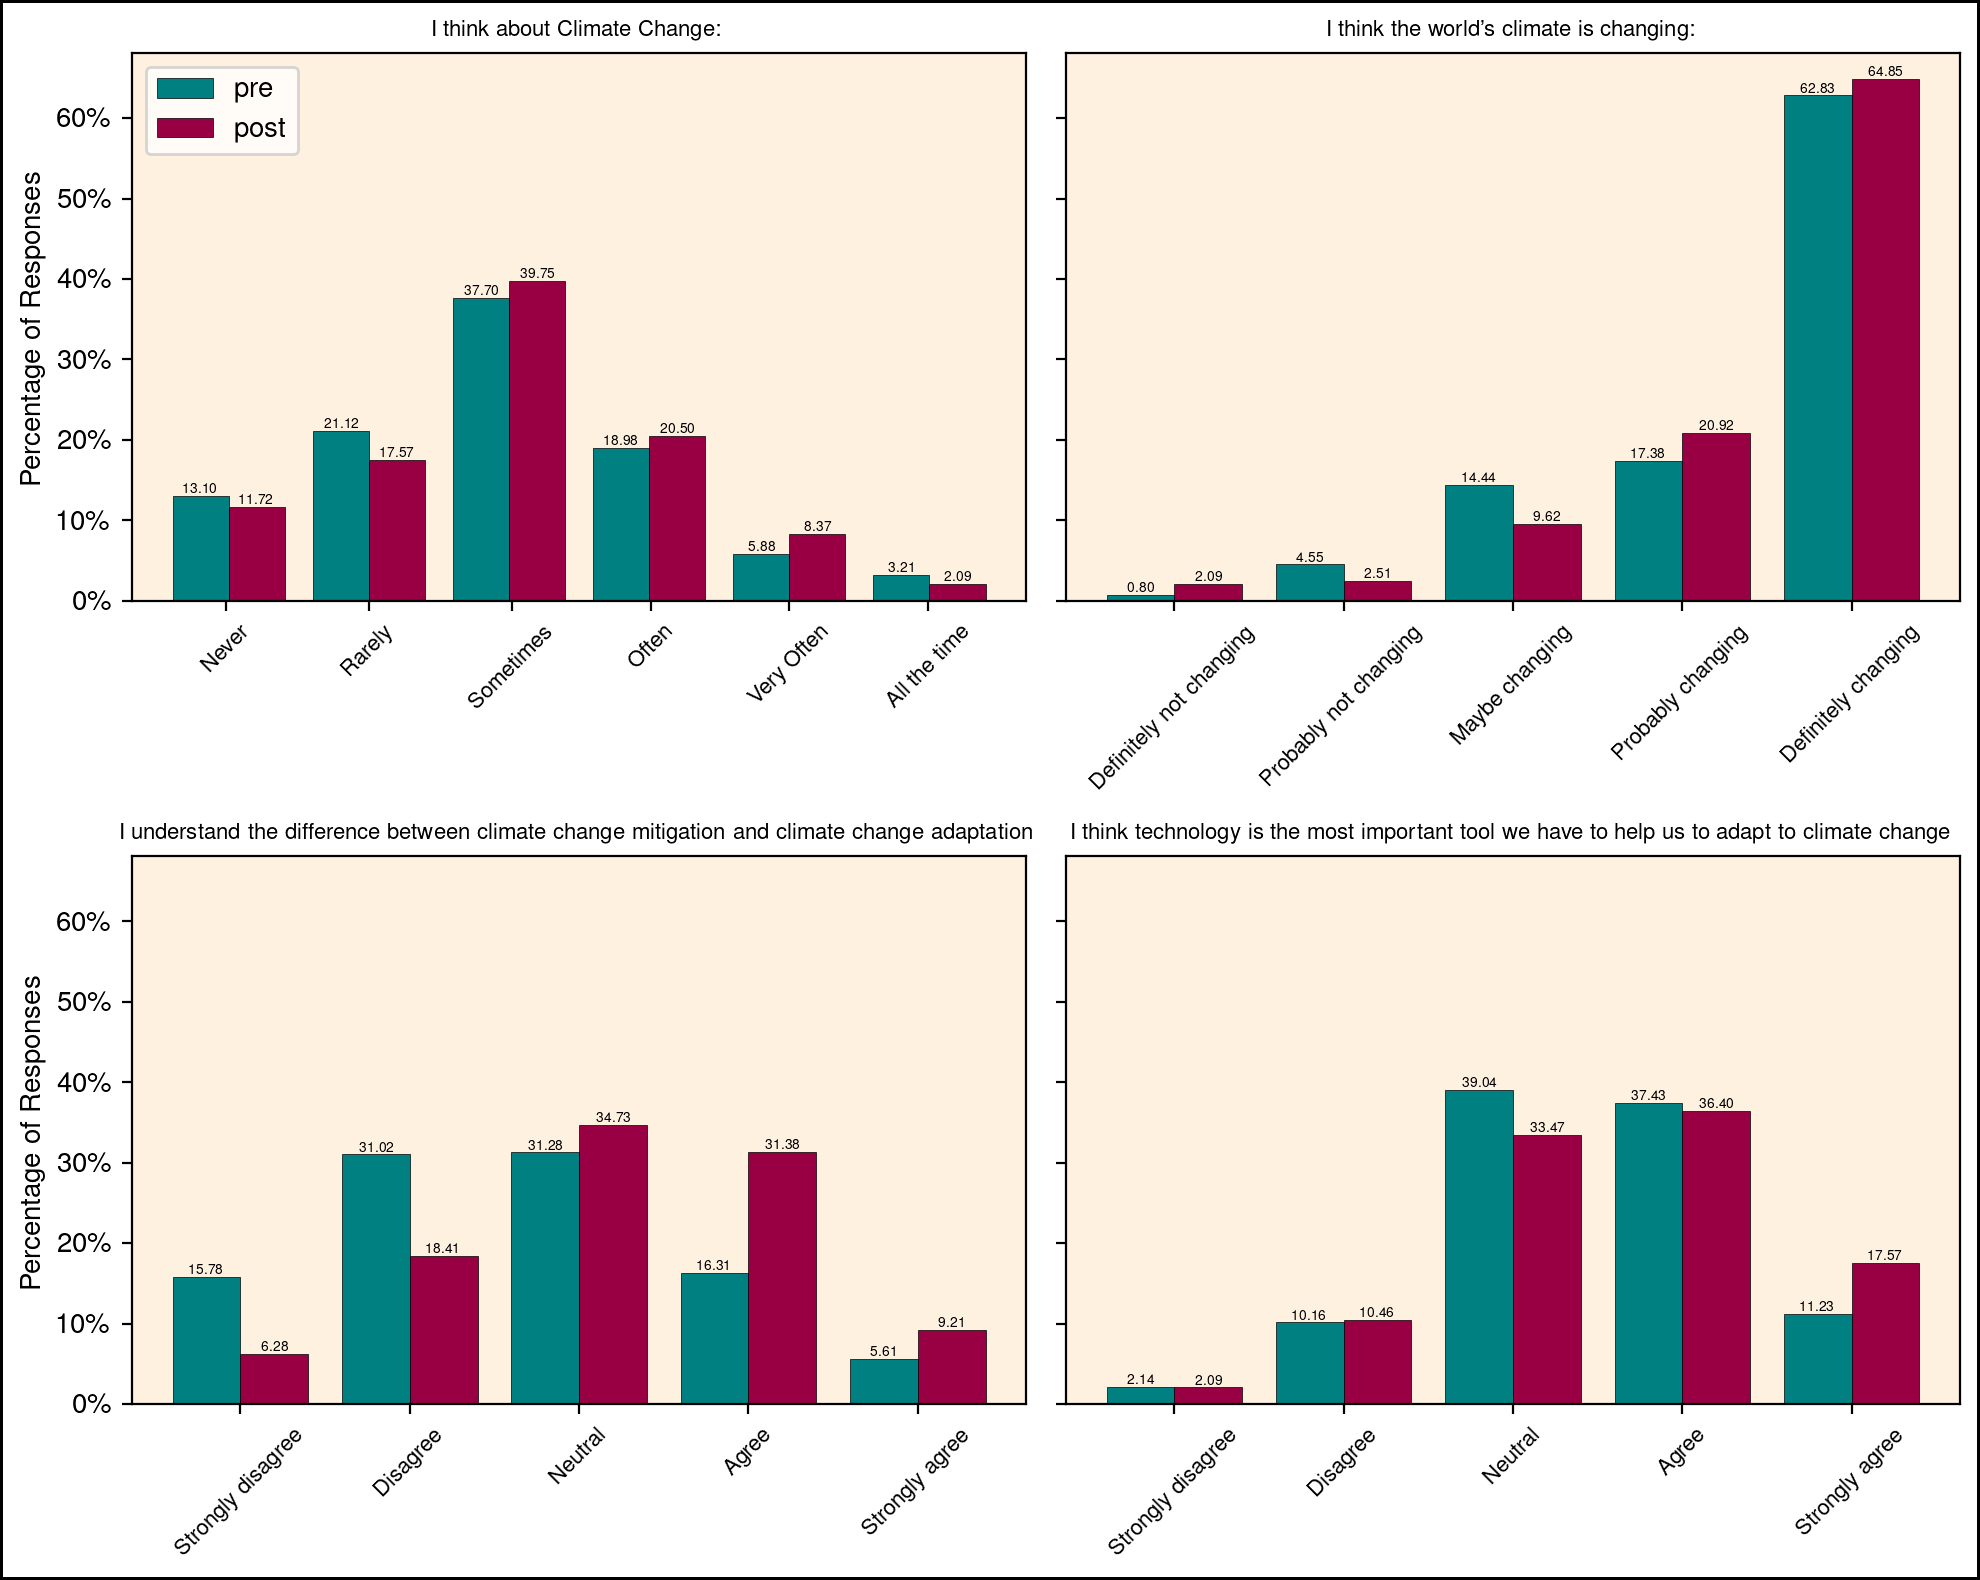

In [36]:
tsize=8
ssize=5

plt.clf()
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharey=True,
    facecolor="#ffffff",
    edgecolor="#000000",
    linewidth=2,
    figsize=(10, 8)
)

ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

ax1.set_ylabel('Percentage of Responses')


# Q1
pre = df[df['prepost'] == 'pre']['Q1']
post = df[df['prepost'] == 'post']['Q1']


# n contains percentages
(n, bins, patches) = ax1.hist([
    df[df['prepost'] == 'pre']['Q1'],
    df[df['prepost'] == 'post']['Q1']
],
    weights = [
        [100 / len(pre)] * len(pre),
        [100 / len(post)] * len(post),
    ],
    ec=ecc, lw=ecw, color=histcolors,
    bins=6, label=['pre', 'post']
)
ax1.set_facecolor("#FFF1E0")
ax1.set_xticks((1.4, 2.25, 3.1, 3.925, 4.75, 5.575))
ax3.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax1.set_xticklabels(["Never", "Rarely", "Sometimes", "Often", "Very Often", "All the time"], rotation=45, size=tsize)
ax1.set_ylabel('Percentage of Responses')
ax1.legend(loc='upper left')
ax1.set_title("I think about Climate Change:", size=tsize)

for b in patches:
    ax1.bar_label(b, size=ssize, fmt="%.2f %%")


# Q2
ax2 = axes[0, 1]
pre = df[df['prepost'] == 'pre']['Q2']
post = df[df['prepost'] == 'post']['Q2']

# n contains percentages
(n, bins, patches) = ax2.hist([
    df[df['prepost'] == 'pre']['Q2'],
    df[df['prepost'] == 'post']['Q2']
],
    weights = [
        [100 / len(pre)] * len(pre),
        [100 / len(post)] * len(post),
    ],
    ec=ecc, lw=ecw, color=histcolors,
    bins=5, label=['pre', 'post']
)

ax2.set_facecolor("#FFF1E0")
ax2.set_xticks((1.4, 2.2, 3, 3.8, 4.6))
ax3.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax2.set_xticklabels([
    "Definitely not changing",
    "Probably not changing",
    "Maybe changing",
    "Probably changing",
    "Definitely changing"], rotation=45, size=tsize)

ax2.set_title("I think the world's climate is changing:", size=tsize)

for b in patches:
    ax2.bar_label(b, size=ssize, fmt="%.2f %%")

# Q7

pre = df[df['prepost'] == 'pre']['Q7']
post = df[df['prepost'] == 'post']['Q7']


# n contains percentages
(n, bins, patches) = ax3.hist([
    df[df['prepost'] == 'pre']['Q7'],
    df[df['prepost'] == 'post']['Q7']
],
    weights = [
        [100 / len(pre)] * len(pre),
        [100 / len(post)] * len(post),
    ],
    ec=ecc, lw=ecw, color=histcolors,
    bins=5, label=['pre', 'post']
)
ax3.set_facecolor("#FFF1E0")
ax3.set_xticks((1.4, 2.2, 3, 3.8, 4.6))
ax3.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax3.set_xticklabels(["Strongly disagree", "Disagree", "Neutral", "Agree", "Strongly agree"], rotation=45, size=tsize)
ax3.set_ylabel('Percentage of Responses')

ax3.set_title(f"{flipped['Q7']}", size=tsize)
for b in patches:
    ax3.bar_label(b, size=ssize, fmt="%.2f %%")

# Q8

pre = df[df['prepost'] == 'pre']['Q8']
post = df[df['prepost'] == 'post']['Q8']


# n contains percentages
(n, bins, patches) = ax4.hist([
    df[df['prepost'] == 'pre']['Q8'],
    df[df['prepost'] == 'post']['Q8']
],
    weights = [
        [100 / len(pre)] * len(pre),
        [100 / len(post)] * len(post),
    ],
    ec=ecc, lw=ecw, color=histcolors,
    bins=5, label=['pre', 'post']
)
ax4.set_facecolor("#FFF1E0")
ax4.set_xticks((1.4, 2.2, 3, 3.8, 4.6))
ax3.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax4.set_xticklabels(["Strongly disagree", "Disagree", "Neutral", "Agree", "Strongly agree"], rotation=45, size=tsize)

ax4.set_title(f"{flipped['Q8']}", size=tsize)
for b in patches:
    ax4.bar_label(b, size=ssize, fmt="%.2f %%")

plt.tight_layout()
plt.savefig("knowledge_learning.png", edgecolor=fig.get_edgecolor(), dpi=300)
plt.show()

## Agency and Empowerment
### Q3, Q4, Q12

<Figure size 640x480 with 0 Axes>

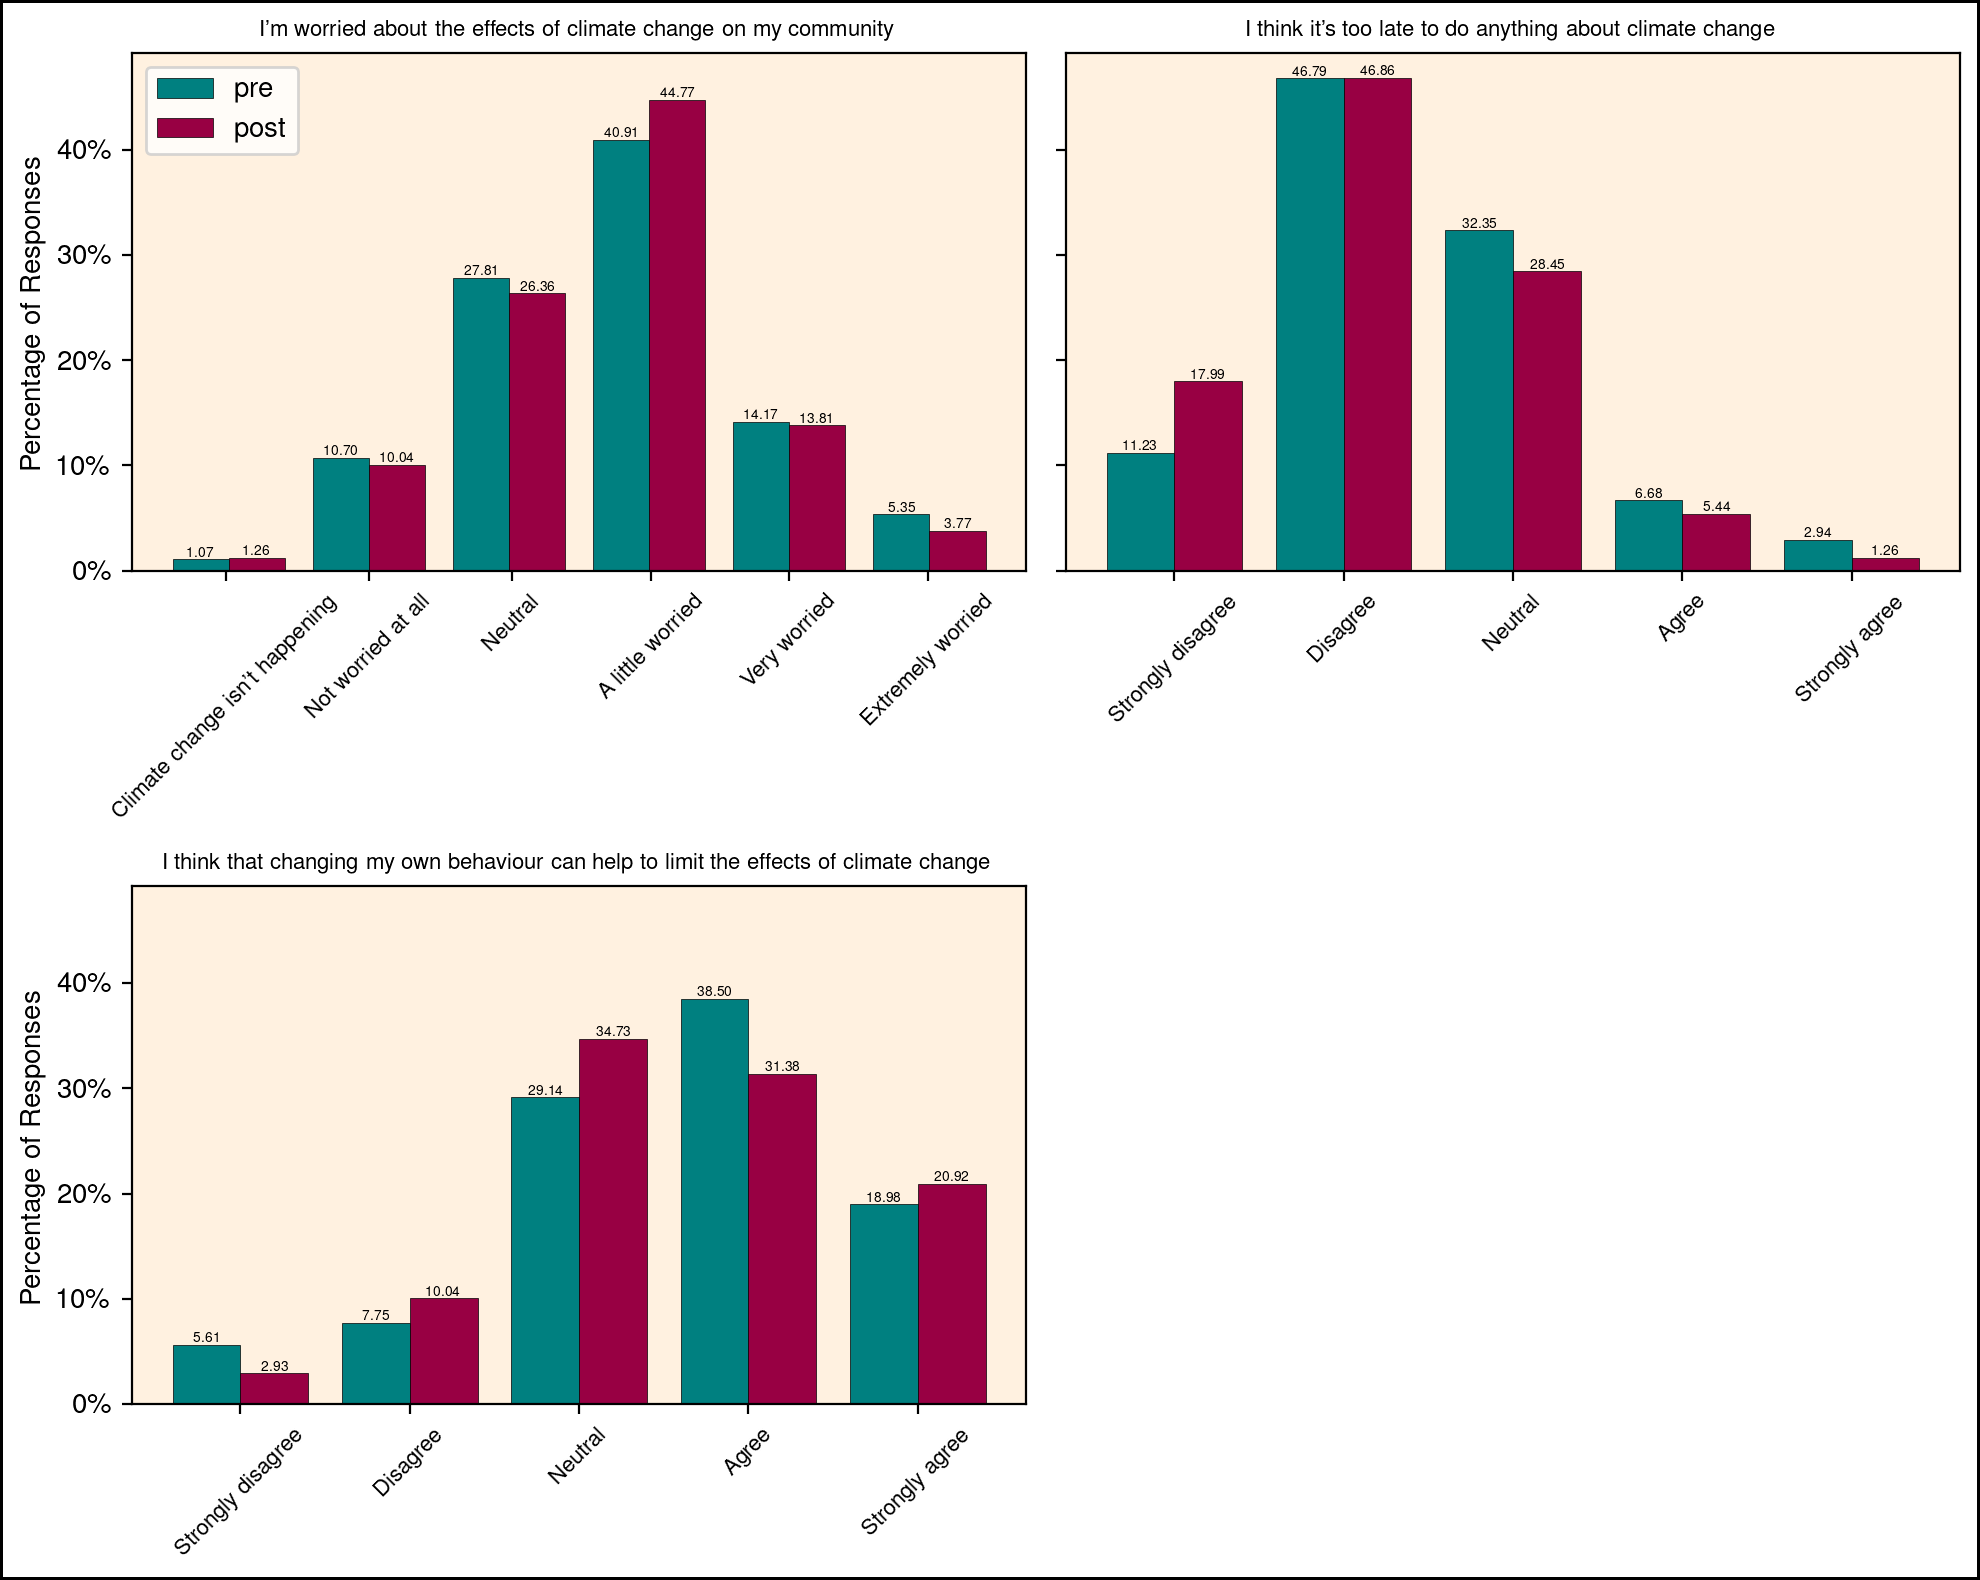

In [38]:
plt.clf()
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharey=True,
    facecolor="#ffffff",
    edgecolor="#000000",
    linewidth=2,
    figsize=(10, 8)
)

ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

ax1.set_ylabel('Percentage of Responses')


# Q3
pre = df[df['prepost'] == 'pre']['Q3']
post = df[df['prepost'] == 'post']['Q3']


# n contains percentages
(n, bins, patches) = ax1.hist([
    df[df['prepost'] == 'pre']['Q3'],
    df[df['prepost'] == 'post']['Q3']
],
    weights = [
        [100 / len(pre)] * len(pre),
        [100 / len(post)] * len(post),
    ],
    ec=ecc, lw=ecw, color=histcolors,
    bins=6, label=['pre', 'post']
)

ax1.set_xticks((1.4, 2.25, 3.1, 3.925, 4.75, 5.575))
ax3.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax1.set_xticklabels(["Climate change isn't happening", "Not worried at all", "Neutral", "A little worried", "Very worried", "Extremely worried"], rotation=45, size=tsize)

ax1.set_facecolor("#FFF1E0")
ax1.set_ylabel('Percentage of Responses')
ax1.legend(loc='upper left')
ax1.set_title("I'm worried about the effects of climate change on my community", size=tsize)

for b in patches:
    ax1.bar_label(b, size=ssize, fmt="%.2f %%")

# Q4
pre = df[df['prepost'] == 'pre']['Q4']
post = df[df['prepost'] == 'post']['Q4']


# n contains percentages
(n, bins, patches) = ax2.hist([
    df[df['prepost'] == 'pre']['Q4'],
    df[df['prepost'] == 'post']['Q4']
],
    weights = [
        [100 / len(pre)] * len(pre),
        [100 / len(post)] * len(post),
    ],
    ec=ecc, lw=ecw, color=histcolors,
    bins=5, label=['pre', 'post']
)
ax2.set_facecolor("#FFF1E0")
ax2.set_xticks((1.4, 2.2, 3, 3.8, 4.6))
ax3.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax2.set_xticklabels(["Strongly disagree", "Disagree", "Neutral", "Agree", "Strongly agree"], rotation=45, size=tsize)

ax2.set_title(f"{flipped['Q4']}", size=tsize)
for b in patches:
    ax2.bar_label(b, size=ssize, fmt="%.2f %%")


# Q12
pre = df[df['prepost'] == 'pre']['Q12']
post = df[df['prepost'] == 'post']['Q12']


# n contains percentages
(n, bins, patches) = ax3.hist([
    df[df['prepost'] == 'pre']['Q12'],
    df[df['prepost'] == 'post']['Q12']
],
    weights = [
        [100 / len(pre)] * len(pre),
        [100 / len(post)] * len(post),
    ],
    ec=ecc, lw=ecw, color=histcolors,
    bins=5, label=['pre', 'post']
)
ax3.set_facecolor("#FFF1E0")
ax3.set_xticks((1.4, 2.2, 3, 3.8, 4.6))
ax3.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax3.set_xticklabels(["Strongly disagree", "Disagree", "Neutral", "Agree", "Strongly agree"], rotation=45, size=tsize)
ax3.set_ylabel('Percentage of Responses')

ax3.set_title(f"{flipped['Q12']}", size=tsize)
for b in patches:
    ax3.bar_label(b, size=ssize, fmt="%.2f %%")
    
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax4.axis('off')

plt.tight_layout()
plt.savefig("agency_empowerment.png", edgecolor=fig.get_edgecolor(), dpi=300)
plt.show()

## Social Networks and Support
### Q6, Q10, Q11

<Figure size 640x480 with 0 Axes>

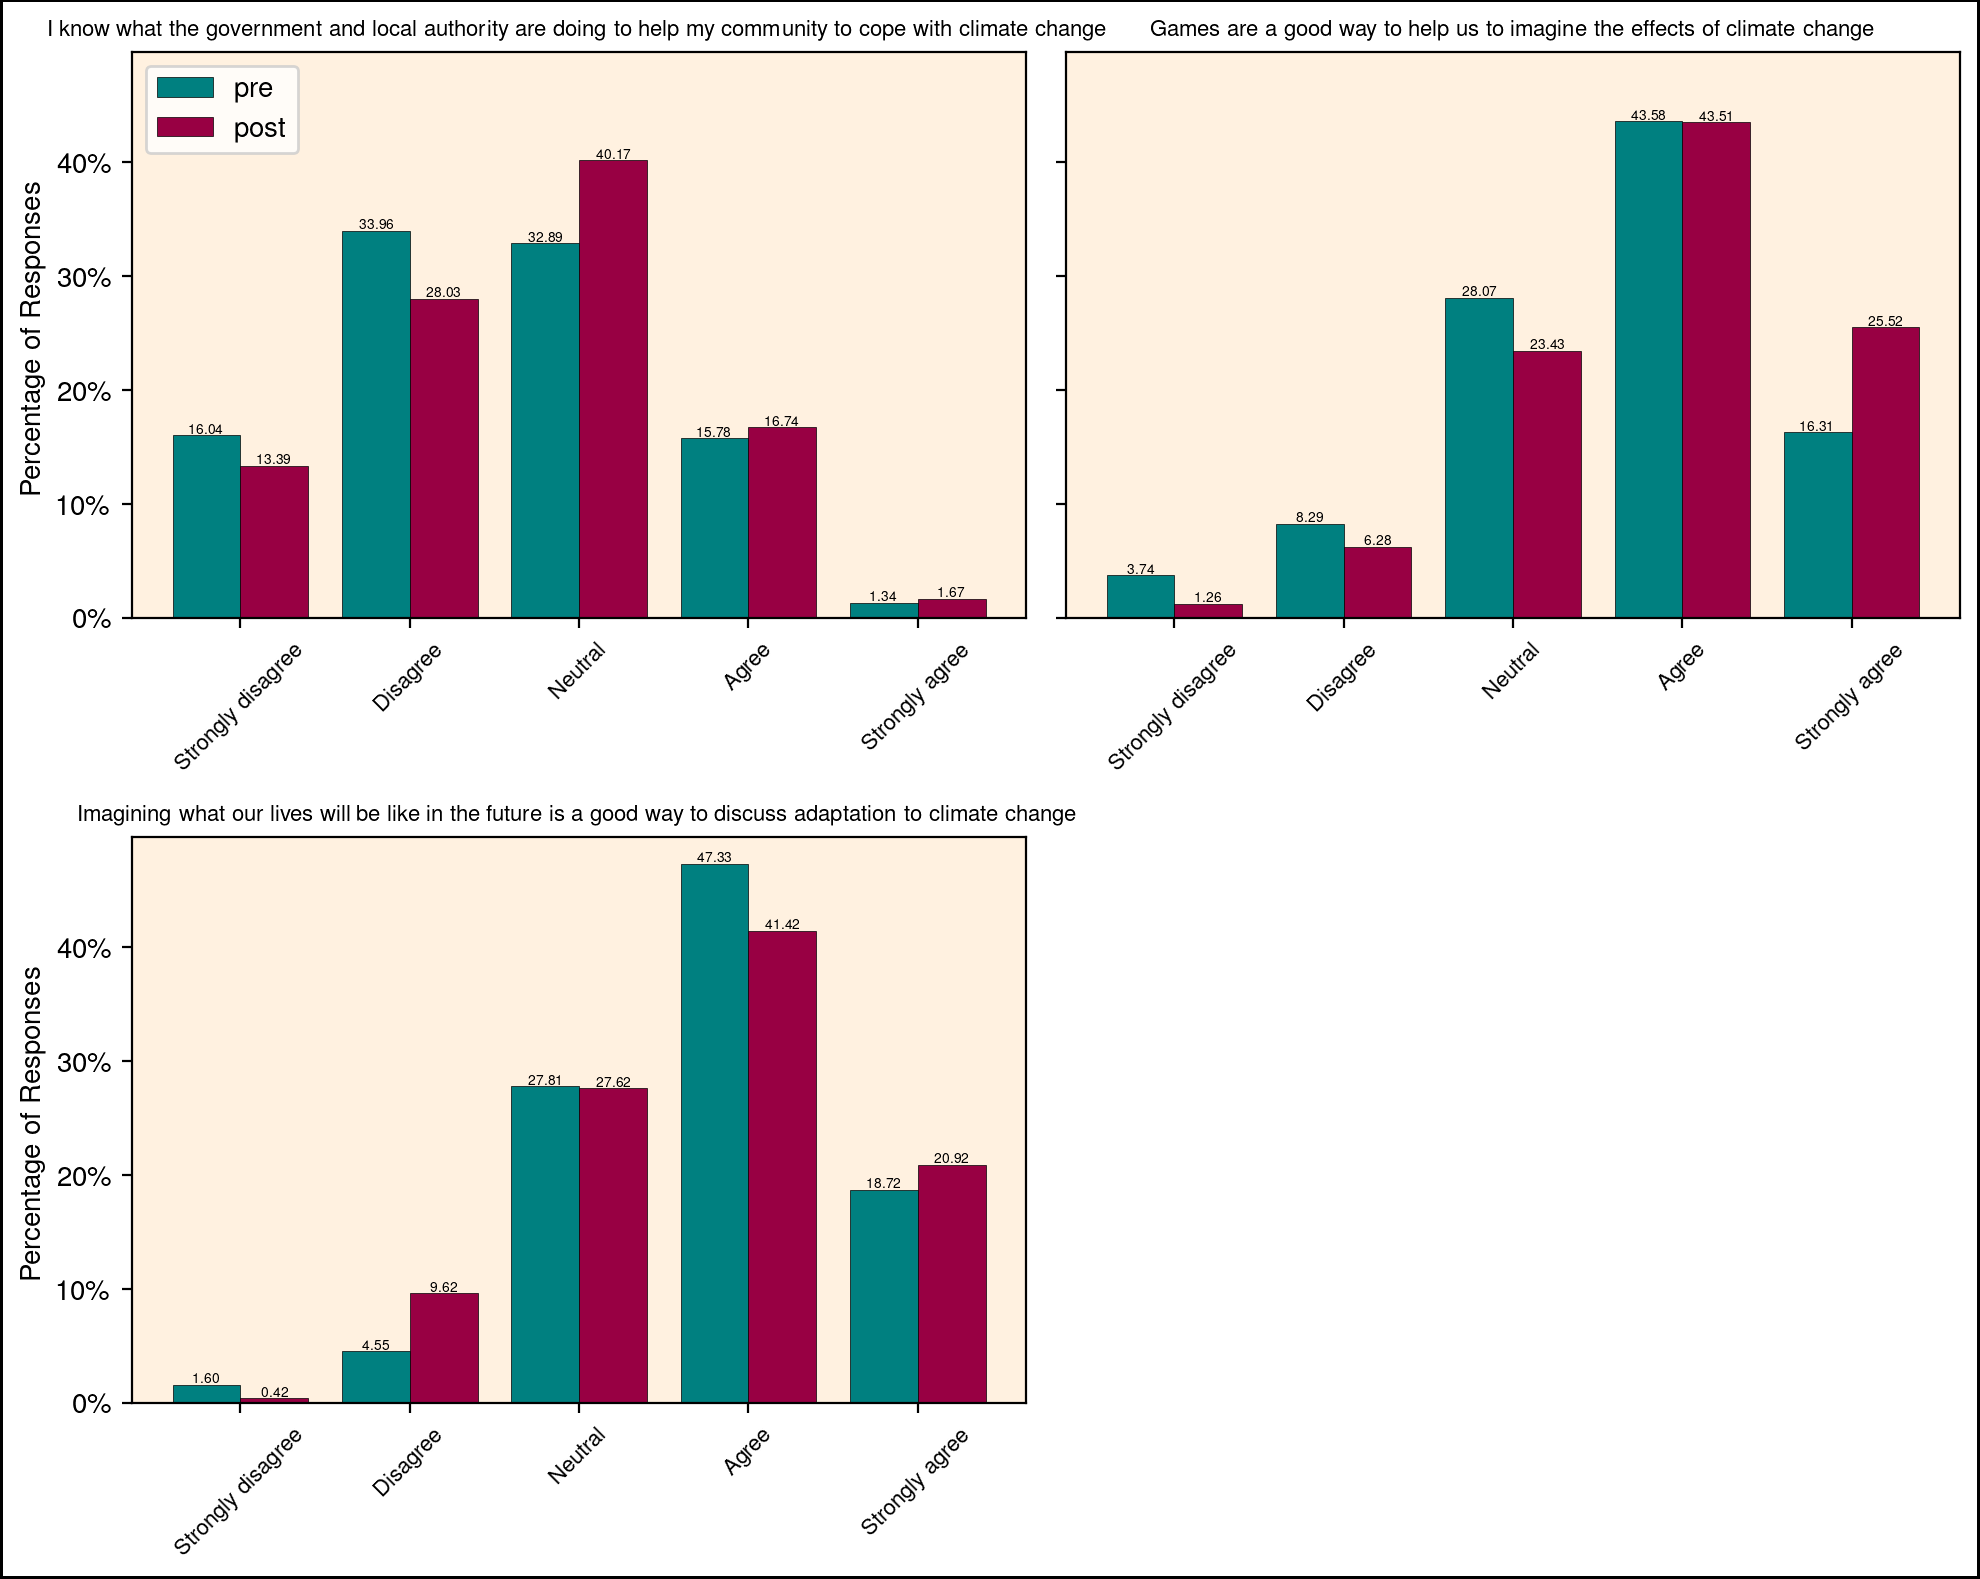

In [39]:
plt.clf()
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharey=True,
    facecolor="#ffffff",
    edgecolor="#000000",
    linewidth=2,
    figsize=(10, 8)
)

ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

ax1.set_ylabel('Percentage of Responses')
ax1.set_facecolor("#FFF1E0")


# Q6
pre = df[df['prepost'] == 'pre']['Q6']
post = df[df['prepost'] == 'post']['Q6']


# n contains percentages
(n, bins, patches) = ax1.hist([
    df[df['prepost'] == 'pre']['Q6'],
    df[df['prepost'] == 'post']['Q6']
],
    weights = [
        [100 / len(pre)] * len(pre),
        [100 / len(post)] * len(post),
    ],
    ec=ecc, lw=ecw, color=histcolors,
    bins=5, label=['pre', 'post']
)

ax1.set_xticks((1.4, 2.2, 3, 3.8, 4.6))
ax1.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax1.set_xticklabels(["Strongly disagree", "Disagree", "Neutral", "Agree", "Strongly agree"], rotation=45, size=tsize)

ax1.set_ylabel('Percentage of Responses')
ax1.legend(loc='upper left')
ax1.set_title(f"{flipped['Q6']}", size=tsize)

for b in patches:
    ax1.bar_label(b, size=ssize, fmt="%.2f %%")

# Q10
pre = df[df['prepost'] == 'pre']['Q10']
post = df[df['prepost'] == 'post']['Q10']


# n contains percentages
(n, bins, patches) = ax2.hist([
    df[df['prepost'] == 'pre']['Q10'],
    df[df['prepost'] == 'post']['Q10']
],
    weights = [
        [100 / len(pre)] * len(pre),
        [100 / len(post)] * len(post),
    ],
    ec=ecc, lw=ecw, color=histcolors,
    bins=5, label=['pre', 'post']
)
ax2.set_facecolor("#FFF1E0")
ax2.set_xticks((1.4, 2.2, 3, 3.8, 4.6))
ax2.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax2.set_xticklabels(["Strongly disagree", "Disagree", "Neutral", "Agree", "Strongly agree"], rotation=45, size=tsize)

ax2.set_title(f"{flipped['Q10']}", size=tsize)
for b in patches:
    ax2.bar_label(b, size=ssize, fmt="%.2f %%")


# Q11
pre = df[df['prepost'] == 'pre']['Q11']
post = df[df['prepost'] == 'post']['Q11']


# n contains percentages
(n, bins, patches) = ax3.hist([
    df[df['prepost'] == 'pre']['Q11'],
    df[df['prepost'] == 'post']['Q11']
],
    weights = [
        [100 / len(pre)] * len(pre),
        [100 / len(post)] * len(post),
    ],
    ec=ecc, lw=ecw, color=histcolors,
    bins=5, label=['pre', 'post']
)
ax3.set_facecolor("#FFF1E0")
ax3.set_xticks((1.4, 2.2, 3, 3.8, 4.6))
ax3.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax3.set_xticklabels(["Strongly disagree", "Disagree", "Neutral", "Agree", "Strongly agree"], rotation=45, size=tsize)
ax3.set_ylabel('Percentage of Responses')

ax3.set_title(f"{flipped['Q11']}", size=tsize)
for b in patches:
    ax3.bar_label(b, size=ssize, fmt="%.2f %%")
    
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax4.axis('off')

plt.tight_layout()
plt.savefig("social_networks_support.png", edgecolor=fig.get_edgecolor(), dpi=300)
plt.show()